In [106]:
from skimage.measure import find_contours, EllipseModel
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
from scipy.spatial import ConvexHull

%matplotlib inline

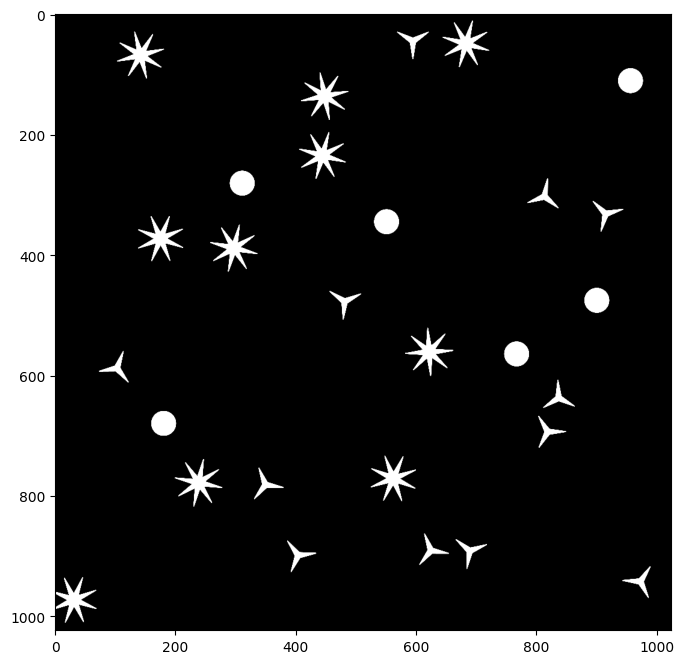

In [11]:
binary_shapes = cv2.imread("./shapes_binary.png", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(8, 8))
plt.imshow(binary_shapes, cmap="gray")
plt.show()

In [9]:
particles = []
processed_pixels = []
pixels_to_process = []


def four_neighbours(y, x):
    if y - 1 >= 0:
        pixels_to_process.append((y - 1, x))
    if y + 1 < binary_shapes.shape[0]:
        pixels_to_process.append((y + 1, x))
    if x - 1 >= 0:
        pixels_to_process.append((y, x - 1))
    if x + 1 < binary_shapes.shape[1]:
        pixels_to_process.append((y, x + 1))


def floodfill():
    particle_pixels = []
    while pixels_to_process:
        pixel = pixels_to_process.pop(0)
        pixel_value = binary_shapes[pixel[0], pixel[1]]
        if pixel not in processed_pixels and pixel_value:
            processed_pixels.append(pixel)
            particle_pixels.append(pixel)
            four_neighbours(*pixel)
    return particle_pixels


for y in range(binary_shapes.shape[0]):
    for x in range(binary_shapes.shape[1]):
        pixel_value = binary_shapes[y, x]
        pixel = (y, x)
        if pixel_value and pixel not in processed_pixels:
            pixels_to_process.append(pixel)
            particle = floodfill()
            particles.append(particle)

In [39]:
with open("./particles.csv", "w") as fp:
    writer = csv.writer(fp, delimiter=";", dialect="unix")
    writer.writerows(particles)

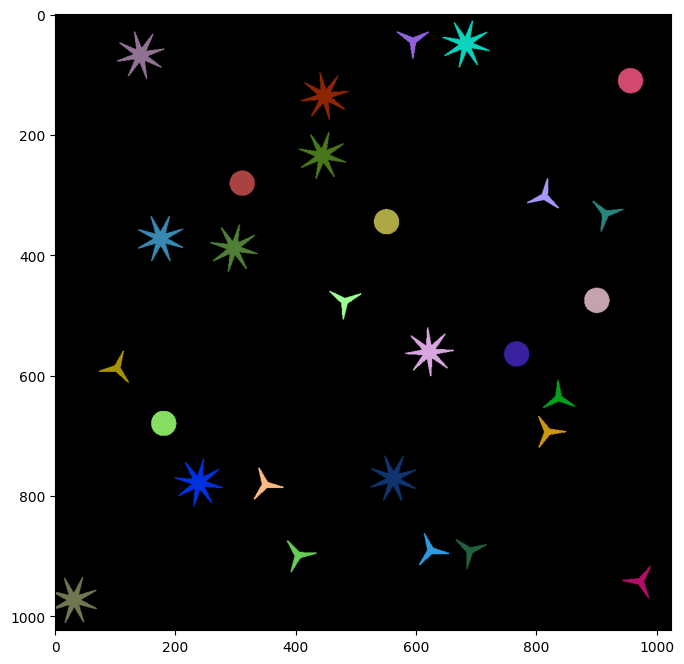

In [10]:
image = np.zeros((*binary_shapes.shape, 3), dtype=np.uint8)
for particle_pixel in particles:
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    for y, x in particle_pixel:
        image[y, x] = (r, g, b)
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

In [16]:
contours = find_contours(binary_shapes)

In [41]:
with open("./contours.csv", "w") as fp:
    writer = csv.writer(fp, delimiter=";", dialect="unix")
    contours_formated = []
    for contour in contours:
        c = []
        for coords in contour:
            c.append((coords[0], coords[1]))
        contours_formated.append(c)
    writer.writerows(contours_formated)

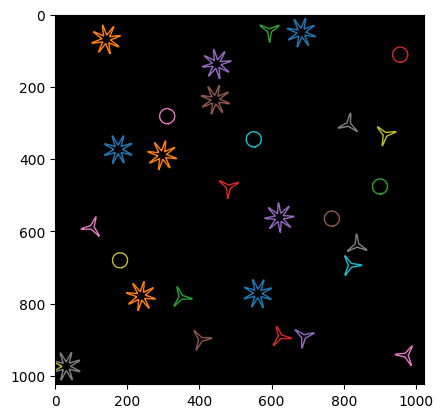

<Figure size 800x800 with 0 Axes>

In [101]:
image = np.zeros((*binary_shapes.shape, 3), dtype=np.uint8)
plt.imshow(image)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=1)
plt.figure(figsize=(8, 8))
plt.show()

In [44]:
particle_areas = []
for particle in particles:
    particle_areas.append(len(particle))

In [60]:
contour_perimeters = []
for contour in contours:
    perimeter = 0 
    for c_index in range(len(contour) - 1):
        y_1, x_1 = contour[c_index]
        y_2, x_2 = contour[c_index + 1]
        perimeter += np.sqrt((y_2 - y_1) ** 2 + (x_2 - x_1) ** 2)
    contour_perimeters.append(perimeter)

In [105]:
porosities = []
for particle_area, particle_contour in zip(particle_areas, contours[0: -1]):
    hull = ConvexHull(particle_contour)
    porosities.append(particle_area / hull.volume)

In [121]:
ellipse_params = []
for particle in particles:
    ellipse = EllipseModel()
    ellipse.estimate(np.array(particle))
    ellipse_params.append(ellipse.params)